# Information

In this exercise we will computationally determine the area of the Mandelbrot set. 

ALL IMPORTS HERE:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from PIL import Image
import colorsys

ALL GLOBAL CONSTANTS HERE:

In [2]:
# Section (i)
MAX_ITERATIONS = 1000
STANDARD_REAL_MIN = -2
STANDARD_REAL_MAX = 1
STANDARD_COMPLEX_MIN = -1.5
STANDARD_COMPLEX_MAX = 1.5

# Section (ii)

# Section (iii)

# Section (iv)

### (i) Visualizing the Mandelbrot set

(~Ayman: feel free to change name of variables, add docstrings, change code, etc... I will try to do this later. Also, we should read PEP 8.)

In [ ]:
def mandelbrot_sequence(c,iter):
    """
    Returns the iteration after which the Mandelbrot sequence diverges. 
    It can be easily shown that this occers when |z_n| > 2. This (slower)
    function is still useful when the amount of iterations before divergence
    is relevant.

    Keyword arguments:
    c -- complex number (being tested whether it is in the Mandelbrot set) 
    """
    z = 0
    counter = 0
    while np.abs(z) <= 2 and counter < iter:
        counter += 1
        z = z ** 2 + c
    return counter

def mandelbrot_diverges(c: np.ndarray[complex], max_iter: int) -> np.ndarray[bool]:
    """
    Returns a boolean array indicating whether each point in the array of complex values diverged
    in the Mandelbrot sequence within the specified number of iterations.

    Args:
        c (np.ndarray): Array of complex numbers to test.
        max_iter (int): Maximum number of iterations.

    Returns:
        np.ndarray: Boolean array where True indicates the corresponding point diverges.
    """
    z = np.zeros(c.shape, dtype=np.complex128)

    diverged = np.zeros(c.shape, dtype=bool)

    for _ in range(max_iter):
        # Mandelbrot iterate points that haven't diverged yet
        z[~diverged] = z[~diverged] ** 2 + c[~diverged]
        
        # Check for divergence and update the diverged array
        diverged |= np.abs(z) > 2

        # Stop if all points have diverged
        if np.all(diverged):
            break

    return diverged

Progress: 100%|██████████| 1000/1000 [03:06<00:00,  5.35it/s]


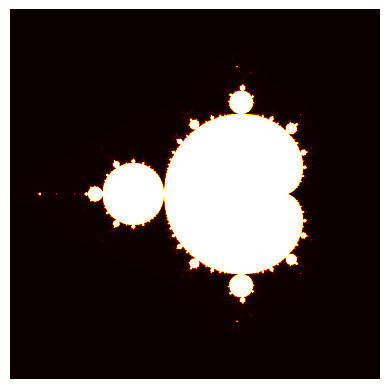

In [4]:
def plot_mandelbrot_fractal(real_min, real_max, imaginary_min, imaginary_max, width, height):
    """
        Inspiration from wiki python + pseudo code + https://medium.com/swlh/visualizing-the-mandelbrot-set-using-python-50-lines-f6aa5a05cf0f.
          (I will add a description later.)
        I will also add comments later when I have time.
    """
    image = np.zeros(shape = (height, width))

    real_range = np.linspace(real_min, real_max, width)
    imaginary_range = np.linspace(imaginary_min, imaginary_max, height)

    for i, real in enumerate(tqdm.tqdm(real_range, desc="Progress")):
        for j, imaginary in enumerate(imaginary_range):
            c = complex(real, imaginary)
            image[j, i] = mandelbrot_sequence(c=c,iter=MAX_ITERATIONS)

    _, ax = plt.subplots()
    ax.imshow(image, cmap="hot", extent=(real_min, real_max, imaginary_min, imaginary_max))
    ax.axis("off")
    plt.show()

# change width and height accordingly
plot_mandelbrot_fractal(STANDARD_REAL_MIN, STANDARD_REAL_MAX, STANDARD_COMPLEX_MIN, STANDARD_COMPLEX_MAX, 1000, 850)

### Improving the image with a colour gradient following a powerlaw. [Inspired by source.]

In [8]:
def powerColor(distance, exp, const, scale):
    color = distance**exp
    rgb = colorsys.hsv_to_rgb(const + scale * color,1 - 0.6 * color,0.9)
    return tuple(round(i * 255) for i in rgb)

def plot_mandelbrot_fractal(real_min, real_max, imaginary_min, imaginary_max, width, height):
    """
        Inspiration from wiki python + pseudo code + https://medium.com/swlh/visualizing-the-mandelbrot-set-using-python-50-lines-f6aa5a05cf0f.
          (I will add a description later.)
        I will also add comments later when I have time.
    """
    
    img = Image.new('RGB', (width, height), color = 'black')
    pixels = img.load()

    real_range = np.linspace(real_min, real_max, width)
    imaginary_range = np.linspace(imaginary_min, imaginary_max, height)

    for i, real in enumerate(tqdm.tqdm(real_range, desc="Progress")):
        for j, imaginary in enumerate(imaginary_range):
            c = complex(real, imaginary)
            # image[j, i] = mandelbrot_sequence(c=c,iter=MAX_ITERATIONS)
            distance = (mandelbrot_sequence(c=c,iter=MAX_ITERATIONS) + 1) / (MAX_ITERATIONS + 1)
            rgb = powerColor(distance, 0.2, 0.27, 1.0)
            pixels[i, j] = rgb

    img.save('output.png')
    plt.show()

# change width and height accordingly
plot_mandelbrot_fractal(STANDARD_REAL_MIN, STANDARD_REAL_MAX, STANDARD_COMPLEX_MIN, STANDARD_COMPLEX_MAX, 1000, 850)

Progress: 100%|██████████| 1000/1000 [00:53<00:00, 18.77it/s]


### (ii) Finding the area using Monte-Carlo:

In [17]:
def mandelbrot_area(complex_values: np.ndarray[complex], num_iteration: int, domain_area: float) -> float:
    """Calculates the area of the Mandelbrot set by iterating a set of complex values a certain
       amount of times and calculating the amount of such values that diverge. The area is then
       equal to that fraction, scaled by the area of the box spanned by the domain.

       complex_values: Numpy array containing complex numbers
       num_iteration: Number of iterations to be executed on every complex number
       domain_area: Area of the box spanned by the items in complex_values
    """
    diverged = mandelbrot_diverges(complex_values, num_iteration)
    bounded = np.count_nonzero(~diverged)
    
    mandelbrot_area = domain_area * bounded / np.shape(complex_values)[0]

    return mandelbrot_area

In [18]:
num_iterations = np.linspace(50, 500, num=50, dtype=int).astype(int)
num_samples = np.linspace(100, 1000, num=50, dtype=int).astype(int)

results_mc = np.zeros((len(num_iterations), len(num_samples)))
# tqdm for progress bar
for it_idx, iteration in enumerate(tqdm.tqdm(num_iterations, desc="Iterations Progress")):
    for sample_idx, sample_size in enumerate(num_samples):
        real_parts = np.random.uniform(STANDARD_REAL_MIN, STANDARD_REAL_MAX, sample_size)
        imag_parts = np.random.uniform(STANDARD_COMPLEX_MIN, STANDARD_COMPLEX_MAX, sample_size)
        complex_values = real_parts + 1j * imag_parts
        
        domain_area = (STANDARD_REAL_MAX - STANDARD_REAL_MIN) * (STANDARD_COMPLEX_MAX - STANDARD_COMPLEX_MIN)

        results_mc[it_idx,sample_idx] = mandelbrot_area(complex_values, iteration, domain_area)


Iterations Progress: 100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


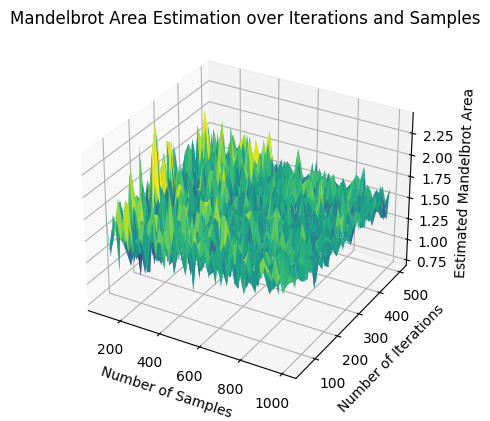

In [19]:
# Plotting the results in 3D
X, Y = np.meshgrid(num_samples, num_iterations)
Z = results_mc

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel("Number of Samples")
ax.set_ylabel("Number of Iterations")
ax.set_zlabel("Estimated Mandelbrot Area")

plt.title("Mandelbrot Area Estimation over Iterations and Samples")
plt.show()

### Latin Hypercube sampling

Comment: I think we need to discuss both LHS and orthogonal!

In [32]:
def lhs_sampling(num_sample, real_min, real_max, imaginary_min, imaginary_max) -> np.ndarray[complex]:
    real_bounds = np.linspace(real_min, real_max, num_sample + 1)
    imag_bounds = np.linspace(imaginary_min, imaginary_max, num_sample + 1)
    
    # I THINK THIS WAS WRONG!
    # real_values = np.random.uniform(low=real_bounds[:-1], high=real_bounds[1:])
    # imag_values = np.random.uniform(low=imag_bounds[:-1], high=imag_bounds[1:])
    
    real_values = np.array([np.random.uniform(low=real_bounds[i], high=real_bounds[i + 1]) 
                            for i in range(num_sample)])
    imag_values = np.array([np.random.uniform(low=imag_bounds[i], high=imag_bounds[i + 1]) 
                            for i in range(num_sample)])
    
    real_values = np.random.permutation(real_values)
    imag_values = np.random.permutation(imag_values)
    
    samples = real_values + 1j * imag_values
    
    return samples

test_lhs_sample = lhs_sampling(1000, STANDARD_REAL_MIN, STANDARD_REAL_MAX, STANDARD_COMPLEX_MIN, STANDARD_COMPLEX_MAX)
domain_area_lhs = (STANDARD_REAL_MAX - STANDARD_REAL_MIN) * (STANDARD_COMPLEX_MAX - STANDARD_COMPLEX_MIN)
test_lhs_mandelbrot_area = mandelbrot_area(test_lhs_sample, 1000, domain_area_lhs)
print(test_lhs_mandelbrot_area)

1.611


In [33]:
num_iterations_LHS = np.linspace(50, 500, num=50, dtype=int).astype(int)
num_samples_LHS = np.linspace(100, 1000, num=50, dtype=int).astype(int)

results_LHS = np.zeros((len(num_iterations_LHS), len(num_samples_LHS)))
# tqdm for progress bar
for it_idx, iteration in enumerate(tqdm.tqdm(num_iterations_LHS, desc="Iterations Progress")):
    for sample_idx, sample_size in enumerate(num_samples_LHS):
        complex_values_lhs = lhs_sampling(sample_size, STANDARD_REAL_MIN, STANDARD_REAL_MAX, STANDARD_COMPLEX_MIN, STANDARD_COMPLEX_MAX)
        domain_area_lhs = (STANDARD_REAL_MAX - STANDARD_REAL_MIN) * (STANDARD_COMPLEX_MAX - STANDARD_COMPLEX_MIN)

        results_LHS[it_idx,sample_idx] = mandelbrot_area(complex_values_lhs, iteration, domain_area_lhs)


Iterations Progress: 100%|██████████| 50/50 [00:19<00:00,  2.53it/s]


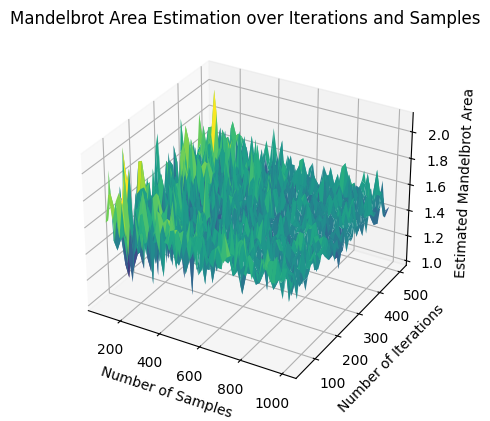

In [28]:
# Plotting the results in 3D
X_LHS, Y_LHS = np.meshgrid(num_samples_LHS, num_iterations_LHS)
Z_LHS = results_LHS

fig_LHS = plt.figure()
ax_LHS = fig_LHS.add_subplot(111, projection='3d')
ax_LHS.plot_surface(X_LHS, Y_LHS, Z_LHS, cmap='viridis')

# Label axes
ax_LHS.set_xlabel("Number of Samples")
ax_LHS.set_ylabel("Number of Iterations")
ax_LHS.set_zlabel("Estimated Mandelbrot Area")

plt.title("Mandelbrot Area Estimation over Iterations and Samples")
plt.show()

In [35]:
print(np.mean(results_LHS[-1]))

1.5053967407727895


In [36]:
print(results_LHS[-1])

[1.71       1.6779661  1.52205882 1.50967742 1.61271676 1.31937173
 1.67142857 1.42105263 1.31707317 1.69811321 1.65371025 1.2218543
 1.575      1.67751479 1.48739496 1.656      1.44274809 1.66019417
 1.56976744 1.48660714 1.85010707 1.44742268 1.30357143 1.48275862
 1.38333333 1.41681574 1.54419411 1.28571429 1.39250814 1.42405063
 1.4516129  1.46636771 1.5720524  1.58073654 1.41712707 1.49191375
 1.59658344 1.3055199  1.32120452 1.56617647 1.5647482  1.56154748
 1.6326062  1.64004499 1.5660793  1.50647948 1.32521186 1.42990654
 1.43119266 1.422     ]


### Orthogonal Sampling

In [ ]:
import numpy as np

# different from the c code -> maybe we should pass the grid-size as the argument if there
# goes something wrong with the code -> I'm not sure
# def orthogonal_sampling(real_min, real_max, imaginary_min, imaginary_max, num_sample):

def orthogonal_sampling(grid_size, real_min, real_max, imaginary_min, imaginary_max):
    num_samples = grid_size**2
    real_scale = (real_max - real_min) / num_samples
    imaginary_scale = (imaginary_max - imaginary_min) / num_samples
    
    xlist = np.arange(num_samples, dtype=int).reshape(grid_size, grid_size)
    ylist = np.arange(num_samples, dtype=int).reshape(grid_size, grid_size)

    for i in range(grid_size):
        np.random.shuffle(xlist[i])  
        np.random.shuffle(ylist[i])  
    
    samples = np.empty((grid_size, grid_size), dtype=np.complex_)
    for i in range(grid_size):
        for j in range(grid_size):  
            x = real_min + real_scale * (xlist[i][j] + np.random.uniform(0, 1))
            y = imaginary_min + imaginary_scale * (ylist[j][i] + np.random.uniform(0, 1))
            samples[i,j] = x + 1j * y

    return samples

grid_size_orth = 50
test_orth_sample = orthogonal_sampling(grid_size_orth, STANDARD_REAL_MIN, STANDARD_REAL_MAX, STANDARD_COMPLEX_MIN, STANDARD_COMPLEX_MAX)
domain_area_orth = (STANDARD_REAL_MAX - STANDARD_REAL_MIN) * (STANDARD_COMPLEX_MAX - STANDARD_COMPLEX_MIN)
extra_scaled_orth_area = domain_area_orth / grid_size_orth
test_orth_mandelbrot_area = mandelbrot_area(test_orth_sample, 1000, extra_scaled_orth_area)
print(test_orth_mandelbrot_area)

1.5084


In [46]:
num_iterations_ORTH = np.linspace(50, 500, num=50, dtype=int).astype(int)

# ok now the square root of this is the number of samples
# so itgoes from 10^2 to 50^2
grid_size_ORTH = np.linspace(10, 100, num=50, dtype=int).astype(int)

results_ORTH = np.zeros((len(num_iterations_ORTH), len(grid_size_ORTH)))
# tqdm for progress bar
for it_idx, iteration in enumerate(tqdm.tqdm(num_iterations_ORTH, desc="Iterations Progress")):
    for sample_idx, grid_size in enumerate(grid_size_ORTH):
        complex_values_orth = orthogonal_sampling(grid_size, STANDARD_REAL_MIN, STANDARD_REAL_MAX, STANDARD_COMPLEX_MIN, STANDARD_COMPLEX_MAX)
        domain_area_orth = (STANDARD_REAL_MAX - STANDARD_REAL_MIN) * (STANDARD_COMPLEX_MAX - STANDARD_COMPLEX_MIN)
        extra_scaled_orth_area = domain_area_orth / grid_size
        
        results_ORTH[it_idx,sample_idx]= mandelbrot_area(complex_values_orth, iteration, extra_scaled_orth_area)

Iterations Progress: 100%|██████████| 50/50 [02:26<00:00,  2.93s/it]


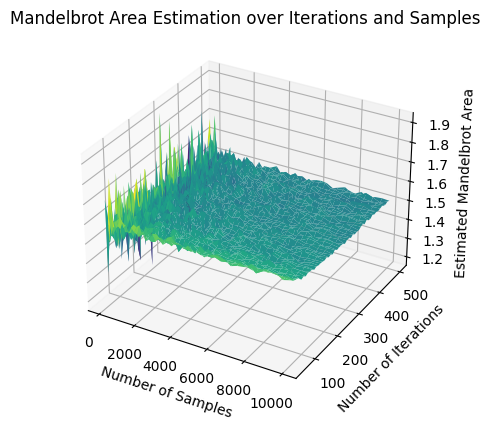

In [47]:
# print(results)
# Plotting the results in 3D
X_ORTH, Y_ORTH = np.meshgrid(grid_size_ORTH**2, num_iterations_ORTH)
Z_ORTH = results_ORTH

fig_ORTH = plt.figure()
ax_ORTH = fig_ORTH.add_subplot(111, projection='3d')
ax_ORTH.plot_surface(X_ORTH, Y_ORTH, Z_ORTH, cmap='viridis')

# Label axes
ax_ORTH.set_xlabel("Number of Samples")
ax_ORTH.set_ylabel("Number of Iterations")
ax_ORTH.set_zlabel("Estimated Mandelbrot Area")

plt.title("Mandelbrot Area Estimation over Iterations and Samples")
plt.show()

In [48]:
print(np.mean(results_ORTH[-1]))

1.5134626872449866
